In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

### Data handler

<AxesSubplot:>

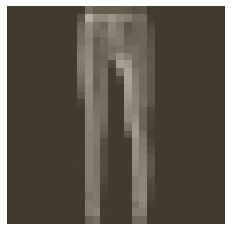

In [2]:
# Define a transformation to normalize the dataset
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                                ])

# Download and load the training data
trainset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=False, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)



# Creating a function to visualize the dataset
def imshow(image, ax=None, title=None, normalize=True):
  """Imshow for Tensor."""
  if ax is None:
      fig, ax = plt.subplots()
  image = image.numpy().transpose((1, 2, 0))
   
  if normalize:
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      image = std * image + mean
      image = np.clip(image, 0, 1)

  ax.imshow(image)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.tick_params(axis='both', length=0)
  ax.set_xticklabels('')
  ax.set_yticklabels('')

  return ax

image, label = next(iter(trainloader))
imshow(image[0,:])

In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [4]:
dataiter

In [5]:
label

tensor([1, 8, 6, 8, 3, 0, 7, 7, 2, 2, 7, 5, 8, 4, 3, 1, 8, 5, 6, 6, 1, 8, 7, 3,
        9, 1, 4, 3, 5, 5, 5, 5, 8, 5, 3, 9, 0, 9, 2, 1, 0, 7, 7, 1, 8, 6, 4, 9,
        4, 9, 2, 7, 3, 6, 2, 3, 1, 2, 3, 9, 3, 7, 2, 3])

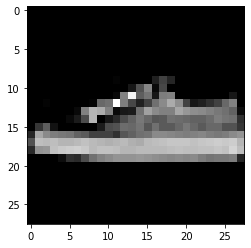

In [6]:
plt.imshow(images[63].numpy().squeeze(), cmap='Greys_r')

### Model

In [ ]:
# #Hyperparameters for our network
# input_size   = 784
# hidden_sizes = [256, 128, 64]
# output_size   = 10

# # Build a feed-forward network
# model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
#                       nn.Dropout(0.2),
#                       nn.ReLU(),
#                       nn.Linear(hidden_sizes[0], hidden_sizes[1]),
#                       nn.Dropout(0.2),
#                       nn.ReLU(),
#                       nn.Linear(hidden_sizes[1], hidden_sizes[2]),
#                       nn.Dropout(0.2),
#                       nn.ReLU(),
#                       nn.Linear(hidden_sizes[2], output_size),
#                       nn.Softmax(dim=1))                          # dim is dimensionality of softmax
# print(model)

In [7]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with a 0.2 drop probability 
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # Flatten the input tensor
        x = x.view(x.shape[0], -1)    
        # Set the activation functions
        layer1 = self.dropout(F.relu(self.fc1(x)))
        layer2 = self.dropout(F.relu(self.fc2(layer1)))
        layer3 = self.dropout(F.relu(self.fc3(layer2)))
        out = F.log_softmax(self.fc4(layer3), dim=1)
    
        return out
    
model = Network()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

### Forward pass

In [8]:
def view_classify(img, ps):

    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize =(6, 9), ncols =2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    #ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

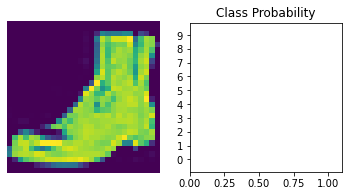

In [10]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to not automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])                          # ps is probablity

img = images[img_idx]
view_classify(img.view(1, 28, 28), ps)

### Training the network

In [17]:
num_epochs = 100
train_losses, test_losses, test_accuracies = [], [], []


for epoch in range(num_epochs):
    train_running_loss = 0 

    for images, labels in trainloader:
        output = model.forward(images)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item()
    

    # validation    
    model.eval()

    # Turn off gradients for validation to save memory and speed up computations
    with torch.no_grad():
        test_running_loss = 0
        acc = 0

        for images, labels in testloader:
            testoutput = model.forward(images)
            testloss = criterion(testoutput, labels)
            test_running_loss += testloss.item()

            ps = torch.exp(testoutput)
            top_p, top_class = ps.topk(1, dim=1)                        # top_p = probability, top_class = index
            equals = top_class == labels.view(*top_class.shape)
            acc += equals.sum().item()
            
    model.train()
    
    # Get mean loss to enable comparison between train and test sets
    train_loss = train_running_loss/ len(trainloader.dataset)
    test_loss = test_running_loss / len(testloader.dataset)
    
    # At completion of epoch
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # test accuracy
    test_accuracies.append(acc / len(testloader.dataset))


    print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
        "Training Loss {:.3f}.. ".format(train_loss),
        "Test Loss {:.3f}.. ".format(test_loss),
        "Test Accuracy {:.2f}%".format(test_accuracies[-1]*100))


# Plots
plt.figure(figsize=(10, 8))
plt.plot(train_losses, marker='o', label='train')
plt.plot(test_losses, marker='o', label='test')
plt.plot(test_accuracies, marker='o', label='test_acc')
plt.legend()

plt.savefig('./learning_curve1.png', dpi = 200)
plt.show()

Epoch: 1/2..  Training Loss 0.006..  Test Loss 0.006..  Test Accuracy 86.520%


KeyboardInterrupt: 

### Save and Load

In [ ]:
torch.save(model.state_dict(), 'checkpoint1.pth')

In [ ]:
state_dict = torch.load('checkpoint1.pth')
print(state_dict.keys())

### Streamlit

In [ ]:
%%writefile app.py
import streamlit as st

@st.cache(allow_output_mutation=True)

def load_model():
  model = torch.load('checkpoint.pth')
  return model
   
with st.spinner('Model is being loaded..'):
  model = load_model()


st.write("""
         # Dress Classification
         """
         )

file = st.file_uploader("Please upload an image file", type=["jpg", "png"])


#import cv2
from PIL import Image, ImageOps
import numpy as np

st.set_option('deprecation.showfileUploaderEncoding', False)

def import_and_predict(image_data, model):
    
        size = (28, 28)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        #img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.
        
        img_reshape = img[np.newaxis,...]
    
        prediction = model.predict(img_reshape)
        
        return prediction

if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = torch.nn.Softmax(predictions[0])
    class_names = ['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot']
    st.write(predictions)
    st.write(score)

    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)